In [1]:
import numpy as np 
import pandas as pd 
import cv2
import copy
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from math import log10, sqrt
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

# DCT & Quantization Modules

## Quantization Tables

In [2]:
#Quantization Arrays

def selectQMatrix(qName):
    
    # Lower Quality => Higher Compression
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    # Higher Quality => Lower Compression
    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8)) 

## Break up image into 8x8 Blocks

In [3]:
def seg(img):
    sliced = [] 
    #dividing 8x8 parts
    currY = 0 #current Y index
    for i in range(block,height+1,block):
        currX = 0 #current X index
        for j in range(block,width+1,block):
            sliced.append(img[currY:i,currX:j]-np.ones((8,8))*128) 
            currX = j
        currY = i
    # Verify blocks
    # print("Each elemend of sliced list contains a "+ str(sliced[0].shape)+ " element")
    imf = [np.float32(img) for img in sliced]
    return imf

## DCT

In [4]:
def to_dct(imf):
    DCToutput = []
    for part in imf:
        currDCT = cv2.dct(part)
        DCToutput.append(currDCT)
    return DCToutput

## Quantize DCT 8x8 Blocks

In [5]:
def to_quant(dctIn, selectedQMatrix):
    ToQuant = copy.deepcopy(dctIn)
    for sect in ToQuant:
        for i in range(block):
            for j in range(block):
                sect[i,j] = np.around(sect[i,j]/selectedQMatrix[i,j])
    return ToQuant

## Dequantize

In [6]:
def de_quant(quantIn, selectedQMatrix):  
    DeQuant = copy.deepcopy(quantIn)
    for sect in DeQuant:
        for i in range(block):
            for j in range(block):
                sect[i,j] = np.around(sect[i,j]*selectedQMatrix[i,j])
    return DeQuant

## Inverse DCT of 8x8 Blocks

In [7]:
def inv_dct(dequantIn):
    invList = []
    for ipart in dequantIn:
        curriDCT = cv2.idct(ipart)
        invList.append(curriDCT)
    return invList

## Piece Together 8x8 Blocks

In [8]:
def inv_seg(invList):   
    row = 0
    rowNcol = []
    for j in range(int(width/block),len(invList)+1,int(width/block)):
        rowNcol.append(np.hstack((invList[row:j])))
        row = j
    res = np.vstack((rowNcol))
    return res

## Resulting Image

## PSNR & SSIM of Result...

In [9]:
# PSNR
def metrics(original, compressed):
    mse = mean_squared_error(original, compressed)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    ssim_res = ssim(original, compressed, data_range=original.max() - original.min())
    ssim_res = (ssim_res + 1) / 2
    return psnr, mse, ssim_res

## Read Image

The image heigh is 512, and image width is 512 pixels


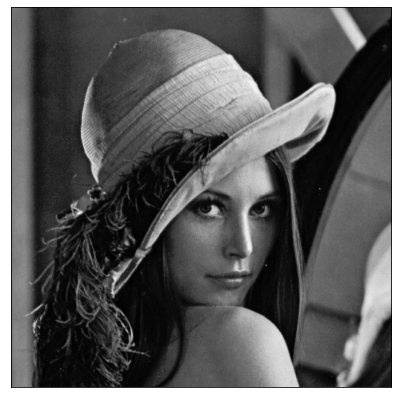

In [10]:
img = cv2.imread("./lena.tif", cv2.IMREAD_GRAYSCALE)
original = cv2.imread("./lena.tif", cv2.IMREAD_GRAYSCALE)
img = np.asarray(img)
height = img.shape[0]
width = img.shape[1]
block = 8
results = []
print("The image heigh is " +str(height)+", and image width is "+str(width)+" pixels")
plt.figure(figsize=(15,7))
plt.imshow(img,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show()

### Q10 Table

In [11]:
# Get segmented image 
img_q10 = cv2.imread("./lena.tif", cv2.IMREAD_GRAYSCALE)
imf = seg(img_q10)
# Get Discrete Cosine Transform 
dct = to_dct(imf)
# Get quant matrix
qmat = selectQMatrix("Q10")
# Quantize
toQuant = to_quant(dct, qmat)
# De-Quantize
invQuant = de_quant(toQuant, qmat)
# Get Inverse Discrete Cosine Transform 
idct = inv_dct(invQuant)
# Get final decompressed image
result1 = inv_seg(idct)
results.append(result1)
# Compare Matrices
print("The DCT Matrix: \n{}".format(dct[0]))
print("The Quantization Table: \n{}".format(qmat))
print("The Quantized Matrix: \n{}".format(toQuant[0]))
print("The Dequantized Matrix: \n{}".format(invQuant[0]))
print("The Inverse DCT Matrix: \n{}".format(idct[0]))
# Get PSNR
psnr1, mse1, ssim1 = metrics(original, result1)
print("For Q10 PSNR = {}, SSIM = {}".format(psnr1, ssim1))

The DCT Matrix: 
[[-1.9112500e+02 -1.6069399e+00 -2.6151175e+00 -1.3977057e-01
  -1.3750000e+00  6.4317977e-01  4.4656930e+00 -2.2185645e+00]
 [ 8.8919554e+00 -1.0649366e-01  3.3618742e-01 -1.5991646e+00
  -5.3983194e-01 -1.0196013e+00  2.8958955e-01 -2.6293251e-01]
 [ 5.8563197e-01  1.4471067e+00  8.1694180e-01  7.0074075e-01
  -1.5095116e+00  6.6464365e-01  2.3483500e-01  2.5927708e-01]
 [-1.7600563e+00 -4.1506128e+00  2.9644957e-01 -5.9645486e-01
   7.2800732e-01 -4.8491114e-01 -1.4260511e-01 -3.9883155e-01]
 [ 1.1250000e+00 -1.7610734e+00  1.6448106e+00  8.1244421e-01
  -1.6250000e+00  3.0445674e-01 -2.7540579e-01 -9.1288596e-01]
 [-2.2685289e-01 -8.8605292e-02  5.0956732e-01  1.1864226e-01
   3.5430294e-02  9.6454829e-02  2.6386079e-01 -1.0251584e-01]
 [ 4.3391842e-01 -2.4581619e-02 -7.6516521e-01 -2.8718066e-01
  -5.1234998e-02 -6.6609687e-01 -6.6941701e-02  6.4085208e-02]
 [-3.1044427e-01 -1.5937912e-01  3.3093697e-01  4.7150427e-01
  -4.8972592e-01  3.8827237e-01  3.6207262e-01

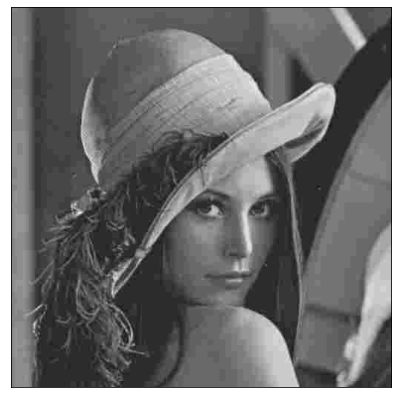

In [12]:
plt.figure(figsize=(15,7))
plt.imshow(result1,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show()

### Q50 Table

In [13]:
# Get segmented image 
img_q50 = cv2.imread("./lena.tif", cv2.IMREAD_GRAYSCALE)
imf = seg(img_q50)
# Get Discrete Cosine Transform 
dct = to_dct(imf)
# Get quant matrix
qmat = selectQMatrix("Q50")
# Quantize
toQuant = to_quant(dct, qmat)
# De-Quantize
invQuant = de_quant(toQuant, qmat)
# Get Inverse Discrete Cosine Transform 
idct = inv_dct(invQuant)
# Get final decompressed image
result2 = inv_seg(idct)
results.append(result2)
# Compare Matrices
print("The DCT Matrix: \n{}".format(dct[0]))
print("The Quantization Table: \n{}".format(qmat))
print("The Quantized Matrix: \n{}".format(toQuant[0]))
print("The Dequantized Matrix: \n{}".format(invQuant[0]))
print("The Inverse DCT Matrix: \n{}".format(idct[0]))
# Get PSNR
psnr2, mse2, ssim2  = metrics(original, result2)
print("For Q50 PSNR = {}, SSIM = {}".format(psnr2, ssim2))

The DCT Matrix: 
[[-1.9112500e+02 -1.6069399e+00 -2.6151175e+00 -1.3977057e-01
  -1.3750000e+00  6.4317977e-01  4.4656930e+00 -2.2185645e+00]
 [ 8.8919554e+00 -1.0649366e-01  3.3618742e-01 -1.5991646e+00
  -5.3983194e-01 -1.0196013e+00  2.8958955e-01 -2.6293251e-01]
 [ 5.8563197e-01  1.4471067e+00  8.1694180e-01  7.0074075e-01
  -1.5095116e+00  6.6464365e-01  2.3483500e-01  2.5927708e-01]
 [-1.7600563e+00 -4.1506128e+00  2.9644957e-01 -5.9645486e-01
   7.2800732e-01 -4.8491114e-01 -1.4260511e-01 -3.9883155e-01]
 [ 1.1250000e+00 -1.7610734e+00  1.6448106e+00  8.1244421e-01
  -1.6250000e+00  3.0445674e-01 -2.7540579e-01 -9.1288596e-01]
 [-2.2685289e-01 -8.8605292e-02  5.0956732e-01  1.1864226e-01
   3.5430294e-02  9.6454829e-02  2.6386079e-01 -1.0251584e-01]
 [ 4.3391842e-01 -2.4581619e-02 -7.6516521e-01 -2.8718066e-01
  -5.1234998e-02 -6.6609687e-01 -6.6941701e-02  6.4085208e-02]
 [-3.1044427e-01 -1.5937912e-01  3.3093697e-01  4.7150427e-01
  -4.8972592e-01  3.8827237e-01  3.6207262e-01

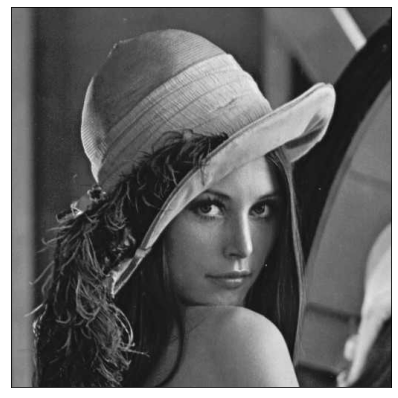

In [14]:
plt.figure(figsize=(15,7))
plt.imshow(result2,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show()

### Q90 Table

In [15]:
# Get segmented image 
img_q90 = cv2.imread("./lena.tif", cv2.IMREAD_GRAYSCALE)
imf = seg(img_q90)
# Get Discrete Cosine Transform 
dct = to_dct(imf)
# Get quant matrix
qmat = selectQMatrix("Q90")
# Quantize
toQuant = to_quant(dct, qmat)
# De-Quantize
invQuant = de_quant(toQuant, qmat)
# Get Inverse Discrete Cosine Transform 
idct = inv_dct(invQuant)
# Get final decompressed image
result3 = inv_seg(idct)
results.append(result3)
# Compare Matrices
print("The DCT Matrix: \n{}".format(dct[0]))
print("The Quantization Table: \n{}".format(qmat))
print("The Quantized Matrix: \n{}".format(toQuant[0]))
print("The Dequantized Matrix: \n{}".format(invQuant[0]))
print("The Inverse DCT Matrix: \n{}".format(idct[0]))
# Get PSNR
psnr3, mse3, ssim3 = metrics(original, result3)
print("For Q90 PSNR = {} SSIM = {}".format(psnr3, ssim3))

The DCT Matrix: 
[[-1.9112500e+02 -1.6069399e+00 -2.6151175e+00 -1.3977057e-01
  -1.3750000e+00  6.4317977e-01  4.4656930e+00 -2.2185645e+00]
 [ 8.8919554e+00 -1.0649366e-01  3.3618742e-01 -1.5991646e+00
  -5.3983194e-01 -1.0196013e+00  2.8958955e-01 -2.6293251e-01]
 [ 5.8563197e-01  1.4471067e+00  8.1694180e-01  7.0074075e-01
  -1.5095116e+00  6.6464365e-01  2.3483500e-01  2.5927708e-01]
 [-1.7600563e+00 -4.1506128e+00  2.9644957e-01 -5.9645486e-01
   7.2800732e-01 -4.8491114e-01 -1.4260511e-01 -3.9883155e-01]
 [ 1.1250000e+00 -1.7610734e+00  1.6448106e+00  8.1244421e-01
  -1.6250000e+00  3.0445674e-01 -2.7540579e-01 -9.1288596e-01]
 [-2.2685289e-01 -8.8605292e-02  5.0956732e-01  1.1864226e-01
   3.5430294e-02  9.6454829e-02  2.6386079e-01 -1.0251584e-01]
 [ 4.3391842e-01 -2.4581619e-02 -7.6516521e-01 -2.8718066e-01
  -5.1234998e-02 -6.6609687e-01 -6.6941701e-02  6.4085208e-02]
 [-3.1044427e-01 -1.5937912e-01  3.3093697e-01  4.7150427e-01
  -4.8972592e-01  3.8827237e-01  3.6207262e-01

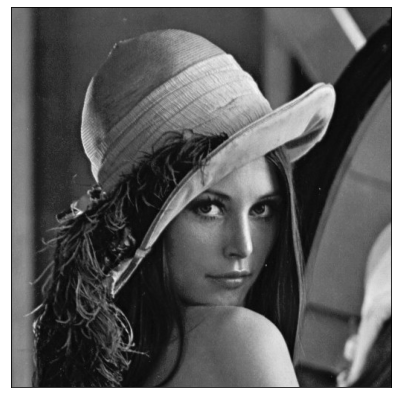

In [16]:
# Plot
plt.figure(figsize=(15,7))
plt.imshow(result3,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show()